In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy
from datetime import datetime, timedelta
import glob
import re

%load_ext autoreload
%autoreload 2
import peregrine
import peregrine.acquisition
import peregrine.analysis.samples
import peregrine.analysis.acquisition

import peregrine.include.generateCAcode
import peregrine.samples
import peregrine.tracking
import peregrine.initSettings
import peregrine.ephemeris
import peregrine.gps_time
import peregrine.navigation as nav
import peregrine.gps_constants as gps
import peregrine.sig_gen as sg
import peregrine.parallel_processing as pp

import swiftnav.track
import swiftnav.correlate

import tricks
from tricks import *

fs=16.368e6; fi=fs/4

In [12]:
run='/home/henry/Documents/car1-lot1-20150722-121630.1bit'; num_skip=int(fs*15); num_samples=int(fs*40)
s = peregrine.samples.load_samples(run, file_format='1bit', 
                                       num_samples=num_samples, num_skip=num_skip)

100% Time: 0:00:06                                                             
PRN  1 SNR  28.02 @ CP  379.7, -2260.07 Hz A
PRN  6 SNR  79.36 @ CP  932.8, +3478.42 Hz A
PRN 13 SNR 107.44 @ CP  358.8, -2738.76 Hz A
PRN 15 SNR 136.56 @ CP  363.1, -1474.11 Hz A
PRN 17 SNR 232.12 @ CP  470.9,  -723.05 Hz A
PRN 24 SNR 138.04 @ CP  126.9, +3221.84 Hz A
PRN 28 SNR 184.19 @ CP 1020.0, -1229.46 Hz A
PRN 46 SNR  32.29 @ CP  981.4,  +444.41 Hz A
PRN 48 SNR 123.66 @ CP  101.5,  +365.94 Hz A
PRN 51 SNR 104.88 @ CP  443.6,  +401.37 Hz A


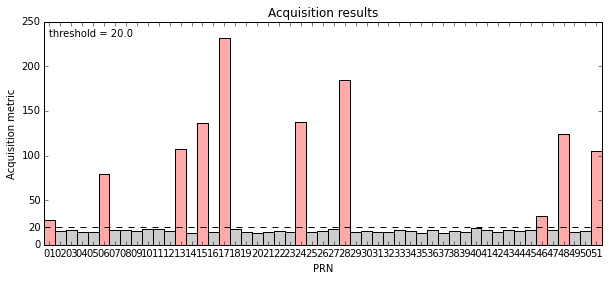

In [14]:
prns_search = range(51)
A = peregrine.acquisition.Acquisition(s, fs, fi, (gps.chips_per_code * fs / gps.chip_rate), 
                                      n_codes_integrate=4)
acq = A.acquisition(prns=prns_search, show_progress=True, doppler_search=7000, threshold=24)
acqed = [a for a in acq if a.status=='A']
peregrine.analysis.acquisition.snr_bars(acq)
peregrine.analysis.acquisition.acq_table(acq)

In [19]:
prns_to_track = [17, 48, 51]

coherent_len = 1; s2bw = 20
ms_to_track = None #100 * 1000
chans = [a for a in acqed if a.prn+1 in prns_to_track]

track_res={tr.prn: tr for tr in peregrine.tracking.track(s, chans,
                                     ms_to_track=ms_to_track,
                                     sampling_freq=fs,
                                     stage1_loop_filter_params=(
                                        (1, 0.7, 1),     # Code loop parameters
                                        (15, 0.7, 1),    # Carrier loop parameters
                                        1e3,             # Loop frequency
                                        5,               # Carrier loop aiding_igain
                                        1540),
                                     stage2_coherent_ms=coherent_len,
                                     stage2_loop_filter_params=(
                                        (1, 0.7, 1),     # Code loop parameters
                                        (s2bw, 0.7, 1),    # Carrier loop parameters
                                        1e3/coherent_len,# Loop frequency
                                        0,               # Carrier loop aiding_igain
                                        1540),
                                     multi=(prns_to_track > 1)}

100% Time: 0:00:36                                                             


0 .. 39977 <=> 0.0011 .. 39.9781


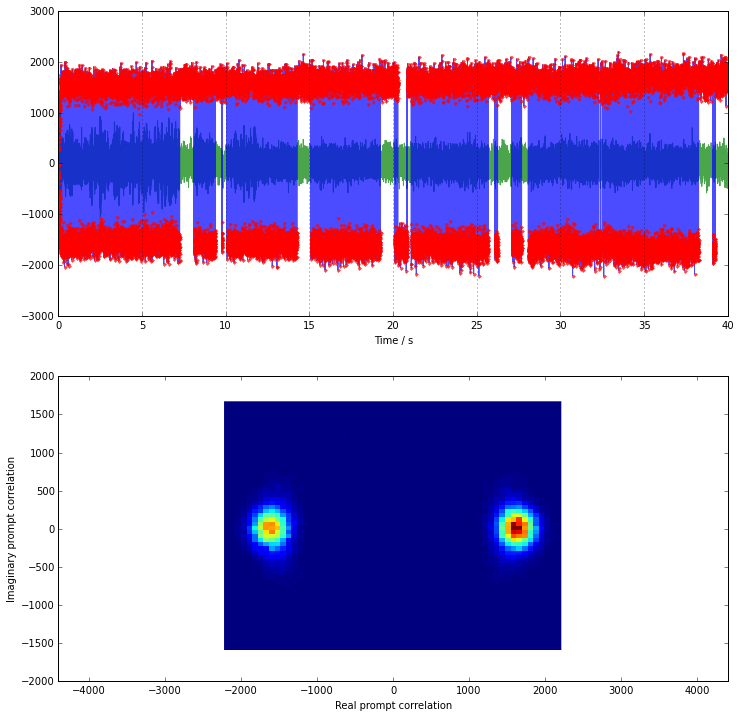

In [23]:
tr = track_res[48-1]
plot_tr(tr, plots=['P','IQ'])

[ 1.  0.  0. ...,  1.  1.  1.]


(-0.5, 1.5)

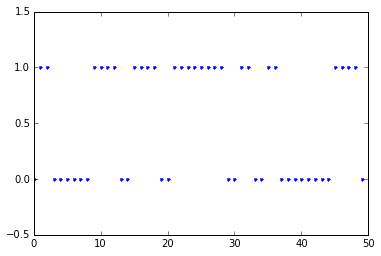

In [35]:
nav_msg_syms_raw = (np.sign(np.real(tr.P))+1)/2
print nav_msg_syms_raw
plt.plot(nav_msg_syms_raw[1000:][:50],'.')
plt.ylim(-0.5, 1.5)

# These are every ms, i.e. two of these samples make up each 500 Hz SBAS message symbol.
# Alignment is unknown.